In [1]:
%matplotlib inline

# 1) Wipe out your namespace
%reset -f

# 2) Clear Jupyter’s stored outputs (and inputs if you like)
try:
    Out.clear() 
except NameError:
    pass

try:
    In.clear()
except NameError:
    pass

# 3) Force Python GC
import gc
gc.collect()

# 4) Free any GPU buffers
import torch
if torch.cuda.is_available():
    torch.cuda.empty_cache()

# 5) remove checkpoints
# import os; _ = [os.remove(p) for p in __import__("glob").glob("libs/.ipynb_checkpoints/*.py") if os.path.exists(p)]

import importlib
from libs import trades, plots, params, feats, strategies, models_core
importlib.reload(trades)
importlib.reload(plots)
importlib.reload(params)
importlib.reload(feats)
importlib.reload(strategies)
importlib.reload(models_core)

<module 'libs.models_core' from '/workspace/my_models/Trading/_Stock_Analysis_/libs/models_core.py'>

In [2]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)

import glob
import os
import json
import re
import psutil
import math
from re import findall

import time
from pathlib import Path
import pickle
import datetime as dt
from datetime import datetime
from datetime import time

import torch.nn.functional as Funct
from torch.utils.data import Dataset, DataLoader
torch.serialization.add_safe_globals([models_core.DayWindowDataset])

# from tqdm.auto import tqdm
from tqdm import tqdm
import json
from PIL import Image
import IPython.display as disp
from IPython.display import clear_output, display

# Turn off interactive plotting globally (we’ll manage our own display)
import matplotlib
import matplotlib.pyplot as plt
plt.ioff()

import seaborn as sns
from pprint import pprint

import optuna
from optuna.trial import TrialState
from optuna.importance import get_param_importances
from optuna.visualization.matplotlib import plot_optimization_history
from optuna.storages import RDBStorage
from optuna.samplers import TPESampler

In [3]:
# ##############################
# ###### ML STRATEGIES DF ######
# ##############################

# df_trainval = pd.read_csv(params.trainval_csv, index_col=0, parse_dates=True)
# baseline_pnl = round((df_trainval["bid"].iloc[-1] - df_trainval["ask"].iloc[0]) / df_trainval.index.normalize().nunique(),4)
# print('baseline profit & loss per day:', baseline_pnl)

# df = df_trainval # SELECT THE CORRECT DATAFRAME
# df.close.plot()
# df

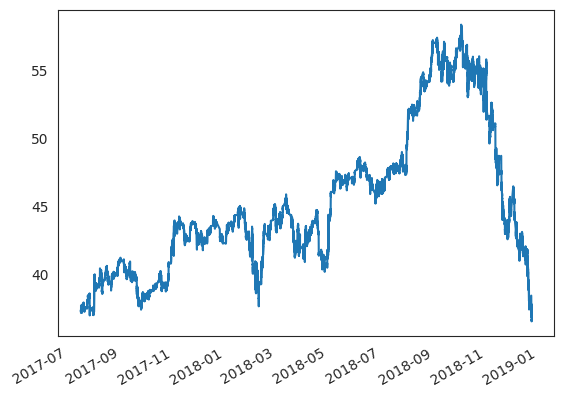

,open,high,low,close,volume,trade_count,vwap,ask,bid,ret,log_ret,sma_5,sma_pct_5,sma_9,sma_pct_9,sma_21,sma_pct_21,sma_50,sma_pct_50,sma_100,sma_pct_100,sma_200,sma_pct_200,ema_9,ema_21,ema_50,roc_5,roc_10,roc_21,body,body_pct,upper_shad,lower_shad,range_pct,rsi_6,rsi_14,rsi_21,macd_line_6_13_5,macd_signal_6_13_5,macd_diff_6_13_5,macd_line_12_26_9,macd_signal_12_26_9,macd_diff_12_26_9,atr_7,atr_pct_7,atr_14,atr_pct_14,atr_28,atr_pct_28,plus_di_7,minus_di_7,adx_7,plus_di_14,minus_di_14,adx_14,plus_di_28,minus_di_28,adx_28,bb_lband_20_2p0,bb_hband_20_2p0,bb_w_20_2p0,bb_lband_20_3p0,bb_hband_20_3p0,bb_w_20_3p0,bb_lband_50_2p0,bb_hband_50_2p0,bb_w_50_2p0,obv,vol_spike_7,vol_spike_14,vol_spike_28,rolling_max_close_200,rolling_min_close_200,dist_high_200,dist_low_200,obv_diff_7,obv_pct_7,obv_diff_21,obv_pct_21,ret_std_21,ret_std_63,stoch_k_14_3_3,stoch_d_14_3_3,stoch_k_9_3_3,stoch_d_9_3_3,cci_14,cci_20,mfi_14,mfi_20,cmf_14,cmf_20,donch_h_20,donch_l_20,donch_w_20,donch_h_55,donch_l_55,donch_w_55,roll_vwap_20,roll_vwap_50,slope_close_20,slope_close_50,kc_mid_20_20_1.5,kc_l_20_20_1.5,kc_h_20_20_1.5,kc_w_20_20_1.5,kc_mid_20_20_2.0,kc_l_20_20_2.0,kc_h_20_20_2.0,kc_w_20_20_2.0,psar,psar_dir,vwap_ohlc_close_session
2017-07-17 08:04:00,37.300000,37.300000,37.300000,37.300000,2400.000000,2.000000,149.200000,37.307450,37.292550,0.001275,0.001274,37.265000,0.000939,37.261944,0.001021,37.257726,0.001135,37.262775,0.000999,37.261963,0.001021,37.260491,0.001060,37.264829,37.260688,37.261018,0.001074,0.001265,0.001154,0.0,0.0,0.0,0.0,0.0,89.668946,83.917085,78.722993,0.005994,0.002121,0.003873,0.002454,-0.000669,0.003123,0.008047,0.000216,0.004502,0.000121,0.003207,0.000086,88.901002,11.093819,56.014570,83.593040,15.981423,36.927554,68.749931,24.186415,15.217115,37.237862,37.277700,0.001069,37.227903,37.287660,0.001604,37.243960,37.281590,0.001010,4.435695e+09,2.391119,3.350618,4.291133,37.33,37.215,0.000804,0.002279,2154.000000,57.804443,-1659.200000,-44.533045,0.000282,0.000174,100.000000,44.444444,100.000000,44.444444,430.266667,575.873828,47.423896,36.894338,0.000000,0.000000,37.3000,37.2525,0.001273,37.3000,37.2525,0.001273,37.264460,37.264327,0.000731,-0.000368,37.260791,37.255432,37.266149,0.000288,37.260791,37.253646,37.267935,0.000383,37.252500,1,37.300000
2017-07-17 08:05:00,37.299554,37.299554,37.299554,37.299554,2381.428571,2.035714,149.198214,37.307004,37.292104,-0.000012,-0.000012,37.272911,0.000715,37.266895,0.000876,37.259770,0.001068,37.263266,0.000974,37.262358,0.000998,37.260707,0.001043,37.271774,37.264221,37.262529,0.001062,0.001263,0.001152,0.0,0.0,0.0,0.0,0.0,88.809157,83.280060,78.212861,0.009585,0.004609,0.004976,0.005197,0.000504,0.004693,0.006961,0.000187,0.004212,0.000113,0.003108,0.000083,88.086535,11.908333,58.895647,82.960215,16.617469,39.048736,68.397295,24.575282,16.357016,37.232992,37.286901,0.001447,37.219515,37.300378,0.002170,37.242069,37.284463,0.001138,4.435693e+09,1.892720,2.776337,3.780468,37.33,37.215,0.000816,0.002267,-827.428572,-22.201391,-3638.428572,-97.650322,0.000282,0.000174,99.060150,66.353383,99.060150,66.353383,231.951214,330.797912,38.400395,31.195063,0.000000,0.000000,37.3000,37.2525,0.001273,37.3000,37.2525,0.001273,37.270486,37.265157,0.001303,-0.000251,37.264482,37.259358,37.269606,0.000275,37.264482,37.257650,37.271314,0.000367,37.252500,1,37.299778
2017-07-17 08:06:00,37.299107,37.299107,37.299107,37.299107,2362.857143,2.071429,149.196429,37.306557,37.291657,-0.000012,-0.000012,37.281232,0.000479,37.271518,0.000740,37.261811,0.001001,37.263748,0.000949,37.262749,0.000976,37.260878,0.001026,37.277240,37.267393,37.263963,0.001117,0.001184,0.001150,0.0,0.0,0.0,0.0,0.0,87.798928,82.604762,77.684290,0.011328,0.006848,0.004479,0.007252,0.001854,0.005399,0.006031,0.000162,0.003943,0.000106,0.003013,0.000081,87.154986,12.839937,61.098958,82.289340,17.291759,40.921755,68.035400,24.974360,17.426313,37.230308,37.293908,0.001707,37.214408,37.309808,0.002560,37.240507,37.286989,0.001247,4.435690e+09,1

In [4]:
##############################
## INDICATORS STRATEGIES DF ##
##############################

# Read sign timestamps ( since selected year, with pre-market included)
df_inds = pd.read_csv(params.indunsc_csv, index_col=0, parse_dates=True) ############### 
df_inds = df_inds[(df_inds.index >= '2017-07-15') & (df_inds.index < '2018-12-25')] #########################

df = df_inds # SELECT THE CORRECT DATAFRAME
df.close.plot()
plt.show()
df

In [5]:
trading_combinations = {
    # EMA based
    # "tc_ema_3_8":     {"col_signal": "ema_3",    "sign_thresh": "ema_8"},
    # "tc_ema_5_13":   {"col_signal": "ema_5",    "sign_thresh": "ema_13"},
    "tc_ema_9_21":   {"col_signal": "ema_9",    "sign_thresh": "ema_21"},
    "tc_ema_21_50":  {"col_signal": "ema_21",    "sign_thresh": "ema_50"},
    
    # # ROC based
    # "tc_roc5_ema21": {"col_signal": "roc_5",    "sign_thresh": "ema_21"},
    # "tc_roc5_zero":  {"col_signal": "roc_5",    "sign_thresh": 0.0},
    # # MACD-based:
    # "tc_macd_line":  {"col_signal": "macd_line_12_26_9", "sign_thresh": 0.0},
    # "tc_macd_diff":  {"col_signal": "macd_diff_6_13_5",  "sign_thresh": 0.0},
    # # RSI gate as signal:
    # "tc_rsi_mid":    {"col_signal": "rsi_14",   "sign_thresh": 50.0},
    # "tc_rsi_fast":   {"col_signal": "rsi_6",    "sign_thresh": 50.0},

}

In [8]:
# Pre-compute per-day slices once
groups = df.groupby(df.index.normalize())
prun_perc = 80 # higher value means the pruner keeps more trials (e.g., 90 keeps the top 10%)
report_interval = 50
_findall = re.compile(r"[+-]?\d+(?:\.\d+)?(?:[eE][+-]?\d+)?").findall

def objective(trial: optuna.Trial) -> float:

    trad_comb = trading_combinations[
        trial.suggest_categorical("tc_id", list(trading_combinations.keys()))
    ]
    
    reset_peak     = trial.suggest_categorical("reset_peak", [True, False])
    
    # RSI band
    rsi_min_thresh = trial.suggest_int("rsi_min_thresh", 3, 70)
    rsi_max_thresh = trial.suggest_int("rsi_max_thresh", rsi_min_thresh + 1, 100)
    # Volume spike threshold (ratio-ish)
    vol_thresh     = trial.suggest_float("vol_thresh", 0.3, 6.0)
    # Trend filter
    adx_thresh     = trial.suggest_float("adx_thresh", 5.0, 50.0)
    # ATR multipliers (log for breadth)
    atr_mult       = trial.suggest_float("atr_mult", 0.3, 10.0, log=True)
    # VWAP+ATR gate; allow negative/positive tilt
    vwap_atr_mult  = trial.suggest_float("vwap_atr_mult", -5.0, 5.0)
    # Scaling factors (wire these into your strategy if used)
    buy_factor     = trial.suggest_float("buy_factor", 0.0, 1.0)
    sell_factor    = trial.suggest_float("sell_factor", 0.0, 1.0)
    # Trailing stop percentage (as percent; kept wider but sane)
    trailstop_pct  = trial.suggest_float("trailstop_pct", 0.2, 20.0)
    # Session start choice
    sess_start = time.fromisoformat(
        trial.suggest_categorical(
            "sess_start",
            [params.sess_premark.isoformat(), params.sess_start_reg.isoformat()],
        )
    )
    
    print('-' * 150)
    print("Params => " + "; ".join(f"{k}={v}" for k, v in dict(trial.params).items()))

    start_ask = df.loc[df.index.normalize() == df.index.normalize().min(), "ask"].iat[0]
    strategies.reset_globals(start_ask)  # necessary to correctly reset the global variables before each independent simulation
    
    daily_pnls: List[float] = []
    daily_bh_pnls: List[float] = []
    trades_count = 0
    holds_count = 0 
    total_bars = 0
    pbar = tqdm(groups, desc=f"Trial {trial.number}", leave=True)

    trial_action_counts = {"Buy": 0, "Sell": 0, "Hold": 0}
    
    for step, (day, df_day) in enumerate(pbar, 1):

        df_actions = strategies.generate_actions_alpaca(
            df              = df_day,
            col_signal      = trad_comb["col_signal"],
            sign_thresh     = trad_comb["sign_thresh"],
            col_atr         = params.col_atr_tick,
            col_adx         = params.col_adx_tick,
            col_vol_spike   = params.col_vol_spike_tick,
            col_rsi         = params.col_rsi_tick,
            col_vwap        = params.col_vwap_tick,
            reset_peak      = reset_peak,
            rsi_min_thresh  = rsi_min_thresh,
            rsi_max_thresh  = rsi_max_thresh,
            vol_thresh      = vol_thresh,
            adx_thresh      = adx_thresh,
            atr_mult        = atr_mult,
            vwap_atr_mult   = vwap_atr_mult,
            trailstop_pct   = trailstop_pct,
            sess_start      = sess_start
        )

        sim_results = strategies.simulate_trading(
            day             = day,
            df              = df_actions,
            buy_factor      = buy_factor,
            sell_factor     = sell_factor,
            sess_start      = sess_start
        )
   
        df_sim, trades, stats = next(iter(sim_results.values()))

        # accumulate executed Action counts from df_sim
        trial_action_counts["Buy"] += int((df_sim["Action"] == "Buy").sum())
        trial_action_counts["Sell"] += int((df_sim["Action"] == "Sell").sum())
        trial_action_counts["Hold"] += int((df_sim["Action"] == "Hold").sum())

        trades_count += len(trades)
        holds_count += int((df_sim["Action"] == "Hold").sum())
        total_bars += len(df_sim)

        daily_pnls.append(strategies._parse_eq_value(stats['STRATEGY']))
        daily_bh_pnls.append(strategies._parse_eq_value(stats['BUYNHOLD']))

        # Explicitly delete large locals at the end of each iteration
        del df_actions, sim_results, stats
        df_day = df_actions = sim_results = stats = None

        if step % report_interval == 0:
            report_step = step // report_interval
            prun_val = np.mean(np.array(daily_pnls) - np.array(daily_bh_pnls))
            
            # sets partial set_user_attr (just to be available if trial pruned)
            trial.set_user_attr("mean_pnl", float(np.mean(daily_pnls)))
            trial.set_user_attr("mean_bh_pnls", float(np.mean(daily_bh_pnls)))
            trial.set_user_attr("action_counts", {k: int(v) for k, v in trial_action_counts.items()})
            
            trial.report(float(prun_val), report_step)
            if trial.should_prune():
                vals = [t.intermediate_values[report_step]
                        for t in trial.study.get_trials(deepcopy=False)
                        if t.state == TrialState.COMPLETE and report_step in t.intermediate_values]
                thr = np.percentile(vals, prun_perc)
                print(f"[PRUNE] value={prun_val:.6f} thr={thr:.6f}")
                pbar.close()
                raise optuna.TrialPruned()

    # sets final set_user_attr
    trial.set_user_attr("mean_pnl", float(np.mean(daily_pnls)))
    trial.set_user_attr("mean_bh_pnls", float(np.mean(daily_bh_pnls)))
    trial.set_user_attr("action_counts", {k: int(v) for k, v in trial_action_counts.items()})
    
    mean_excess = np.mean(np.array(daily_pnls) - np.array(daily_bh_pnls))
    return float(mean_excess)




Baseline mean daily B&H: -4.6186
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=65; rsi_max_thresh=93; vol_thresh=5.943976537034015; adx_thresh=20.540551521877095; atr_mult=0.6253045680222854; vwap_atr_mult=0.8211199839229666; buy_factor=0.9936927120658985; sell_factor=0.1360354571900606; trailstop_pct=19.416267011129783; sess_start=08:00:00


Trial 0: 100%|██████████| 364/364 [00:24<00:00, 15.05it/s]


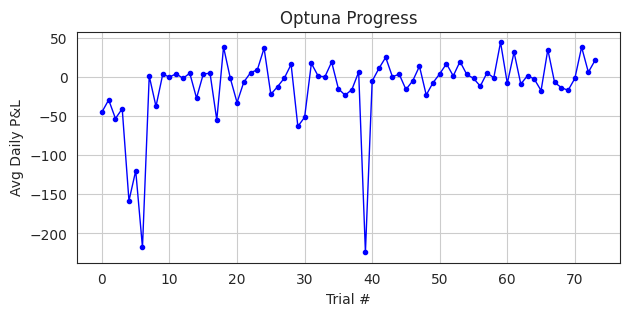

[Results] mean_pnl:-49.9289 mean_excess:-45.0245 improv:818.04%
Action counts: {'Buy': 368, 'Sell': 11555, 'Hold': 322891}
Best trial is: 0 with best_val: -45.0245
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=True; rsi_min_thresh=33; rsi_max_thresh=48; vol_thresh=2.752018228507672; adx_thresh=43.59183331054177; atr_mult=0.9088718704669676; vwap_atr_mult=-0.24266369000434107; buy_factor=0.7307452877722648; sell_factor=0.22872758584426633; trailstop_pct=12.280251116661933; sess_start=08:00:00


Trial 1: 100%|██████████| 364/364 [00:21<00:00, 16.76it/s]


[Results] mean_pnl:-34.3739 mean_excess:-29.4695 improv:500.88%
Action counts: {'Buy': 637, 'Sell': 6330, 'Hold': 327847}
Best trial is: 1 with best_val: -29.4695
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=72; vol_thresh=1.6880273943236903; adx_thresh=20.417302700034558; atr_mult=0.6664929101729394; vwap_atr_mult=1.5903241444505545; buy_factor=0.040487359817501956; sell_factor=0.9810403804111957; trailstop_pct=6.530013244922085; sess_start=08:00:00


Trial 2: 100%|██████████| 364/364 [00:24<00:00, 14.67it/s]


[Results] mean_pnl:-58.2095 mean_excess:-53.3051 improv:986.88%
Action counts: {'Buy': 8781, 'Sell': 3215, 'Hold': 322818}
Best trial is: 1 with best_val: -29.4695
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=True; rsi_min_thresh=11; rsi_max_thresh=29; vol_thresh=2.5731443182832514; adx_thresh=16.3880474502551; atr_mult=1.0110453736162641; vwap_atr_mult=3.306374528093089; buy_factor=0.6566388651830309; sell_factor=0.2619263861691571; trailstop_pct=1.4546735444840213; sess_start=13:30:00


Trial 3: 100%|██████████| 364/364 [00:24<00:00, 15.05it/s]


[Results] mean_pnl:-45.7065 mean_excess:-40.8021 improv:731.95%
Action counts: {'Buy': 1151, 'Sell': 8398, 'Hold': 325265}
Best trial is: 1 with best_val: -29.4695
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_9_21; reset_peak=False; rsi_min_thresh=10; rsi_max_thresh=86; vol_thresh=1.7164047225455445; adx_thresh=17.65158754505048; atr_mult=6.647394109583508; vwap_atr_mult=-3.877934256590666; buy_factor=0.5157680486757856; sell_factor=0.137122055827389; trailstop_pct=5.944674109245298; sess_start=13:30:00


Trial 4: 100%|██████████| 364/364 [00:28<00:00, 12.99it/s]


[Results] mean_pnl:-163.2053 mean_excess:-158.3009 improv:3127.72%
Action counts: {'Buy': 5457, 'Sell': 48311, 'Hold': 281046}
Best trial is: 1 with best_val: -29.4695
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_9_21; reset_peak=False; rsi_min_thresh=33; rsi_max_thresh=56; vol_thresh=0.9343423801302586; adx_thresh=26.550781489188324; atr_mult=0.31250828402422914; vwap_atr_mult=-2.822511660184208; buy_factor=0.21460653374341532; sell_factor=0.3593532963843611; trailstop_pct=16.788459071086606; sess_start=13:30:00


Trial 5: 100%|██████████| 364/364 [00:23<00:00, 15.55it/s]


[Results] mean_pnl:-124.8396 mean_excess:-119.9352 improv:2345.45%
Action counts: {'Buy': 8873, 'Sell': 17277, 'Hold': 308664}
Best trial is: 1 with best_val: -29.4695
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_9_21; reset_peak=True; rsi_min_thresh=15; rsi_max_thresh=68; vol_thresh=1.7747558401204298; adx_thresh=9.767122078824684; atr_mult=1.93707451984786; vwap_atr_mult=-4.443364947477941; buy_factor=0.7932162037889121; sell_factor=0.5619189479747774; trailstop_pct=10.115539606987975; sess_start=13:30:00


Trial 6: 100%|██████████| 364/364 [00:24<00:00, 14.91it/s]


[Results] mean_pnl:-222.6639 mean_excess:-217.7595 improv:4340.07%
Action counts: {'Buy': 5716, 'Sell': 16748, 'Hold': 312350}
Best trial is: 1 with best_val: -29.4695
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_9_21; reset_peak=False; rsi_min_thresh=34; rsi_max_thresh=69; vol_thresh=1.4926035295546904; adx_thresh=42.10942121344; atr_mult=1.4971165091842609; vwap_atr_mult=2.8458409589749154; buy_factor=0.07341289602815759; sell_factor=0.5092586828987193; trailstop_pct=17.41028975657898; sess_start=13:30:00


Trial 7: 100%|██████████| 364/364 [00:22<00:00, 16.30it/s]


[Results] mean_pnl:-3.9422 mean_excess:0.9622 improv:-119.62%
Action counts: {'Buy': 606, 'Sell': 1754, 'Hold': 332454}
Best trial is: 7 with best_val: 0.9622
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=51; rsi_max_thresh=85; vol_thresh=2.263069210002935; adx_thresh=30.23631509178061; atr_mult=6.039390791996624; vwap_atr_mult=3.8133349205818643; buy_factor=0.6722560433455194; sell_factor=0.5326079178914382; trailstop_pct=6.13293445624627; sess_start=13:30:00


Trial 8: 100%|██████████| 364/364 [00:23<00:00, 15.57it/s]


[Results] mean_pnl:-42.6893 mean_excess:-37.7849 improv:670.43%
Action counts: {'Buy': 769, 'Sell': 3101, 'Hold': 330944}
Best trial is: 7 with best_val: 0.9622
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=False; rsi_min_thresh=6; rsi_max_thresh=97; vol_thresh=4.5721164841810245; adx_thresh=40.21522339944343; atr_mult=0.4448608181842246; vwap_atr_mult=-3.1205631790515143; buy_factor=0.044655978158745224; sell_factor=0.6273056065306082; trailstop_pct=9.741304852077324; sess_start=08:00:00


Trial 9: 100%|██████████| 364/364 [00:32<00:00, 11.28it/s]


[Results] mean_pnl:-1.7144 mean_excess:3.1900 improv:-165.04%
Action counts: {'Buy': 209, 'Sell': 746, 'Hold': 333859}
Best trial is: 9 with best_val: 3.1900
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=True; rsi_min_thresh=50; rsi_max_thresh=100; vol_thresh=4.611738771230225; adx_thresh=48.71400187830288; atr_mult=0.32041698257118706; vwap_atr_mult=-1.7893136813590682; buy_factor=0.29742834000344454; sell_factor=0.7745052181500377; trailstop_pct=13.187487271264914; sess_start=08:00:00


Trial 10: 100%|██████████| 364/364 [00:39<00:00,  9.21it/s]


[Results] mean_pnl:-5.1807 mean_excess:-0.2763 improv:-94.37%
Action counts: {'Buy': 94, 'Sell': 335, 'Hold': 334385}
Best trial is: 9 with best_val: 3.1900
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_9_21; reset_peak=False; rsi_min_thresh=4; rsi_max_thresh=5; vol_thresh=3.989439452814914; adx_thresh=38.18043869757649; atr_mult=2.535191618134517; vwap_atr_mult=4.828724504855446; buy_factor=0.02724923564344399; sell_factor=0.6884881856846548; trailstop_pct=14.189113527379341; sess_start=08:00:00


Trial 11: 100%|██████████| 364/364 [00:36<00:00,  9.97it/s]


[Results] mean_pnl:-1.0422 mean_excess:3.8622 improv:-178.75%
Action counts: {'Buy': 200, 'Sell': 537, 'Hold': 334077}
Best trial is: 11 with best_val: 3.8622
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_9_21; reset_peak=False; rsi_min_thresh=4; rsi_max_thresh=6; vol_thresh=4.13268842914814; adx_thresh=35.182739715627534; atr_mult=3.0554605110175848; vwap_atr_mult=4.945298919884093; buy_factor=0.2620260393307157; sell_factor=0.7834795920523998; trailstop_pct=13.967664347545433; sess_start=08:00:00


Trial 12: 100%|██████████| 364/364 [00:31<00:00, 11.55it/s]


[Results] mean_pnl:-6.9580 mean_excess:-2.0535 improv:-58.13%
Action counts: {'Buy': 217, 'Sell': 674, 'Hold': 333923}
Best trial is: 11 with best_val: 3.8622
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_9_21; reset_peak=False; rsi_min_thresh=21; rsi_max_thresh=34; vol_thresh=3.83092453238831; adx_thresh=37.01245707439289; atr_mult=3.400960091994949; vwap_atr_mult=-1.0291754554299652; buy_factor=0.0033026264869323307; sell_factor=0.6997308561523758; trailstop_pct=9.175208072171314; sess_start=08:00:00


Trial 13: 100%|██████████| 364/364 [00:29<00:00, 12.37it/s]


[Results] mean_pnl:-0.2995 mean_excess:4.6049 improv:-193.89%
Action counts: {'Buy': 375, 'Sell': 559, 'Hold': 333880}
Best trial is: 13 with best_val: 4.6049
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_9_21; reset_peak=False; rsi_min_thresh=22; rsi_max_thresh=23; vol_thresh=3.5748539587983585; adx_thresh=34.13696088237345; atr_mult=3.4663671209418103; vwap_atr_mult=-1.0122738100235469; buy_factor=0.40180582313655083; sell_factor=0.7301032905397178; trailstop_pct=9.343644694804029; sess_start=08:00:00


Trial 14: 100%|██████████| 364/364 [00:23<00:00, 15.43it/s]


[Results] mean_pnl:-32.0662 mean_excess:-27.1618 improv:453.82%
Action counts: {'Buy': 570, 'Sell': 1915, 'Hold': 332329}
Best trial is: 13 with best_val: 4.6049
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_9_21; reset_peak=False; rsi_min_thresh=23; rsi_max_thresh=40; vol_thresh=5.63108216570326; adx_thresh=49.212819044474855; atr_mult=9.825920949916929; vwap_atr_mult=1.6021265712904622; buy_factor=0.1637650188066386; sell_factor=0.9125846585891686; trailstop_pct=1.6589587473035667; sess_start=08:00:00


Trial 15: 100%|██████████| 364/364 [00:22<00:00, 15.87it/s]


[Results] mean_pnl:-1.4032 mean_excess:3.5012 improv:-171.39%
Action counts: {'Buy': 40, 'Sell': 93, 'Hold': 334681}
Best trial is: 13 with best_val: 4.6049
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_9_21; reset_peak=False; rsi_min_thresh=17; rsi_max_thresh=18; vol_thresh=3.543544391355683; adx_thresh=36.06817584954094; atr_mult=2.9379383109913113; vwap_atr_mult=-1.5489483775983541; buy_factor=0.002744856881882085; sell_factor=0.39418425508781085; trailstop_pct=15.480523736281985; sess_start=08:00:00


Trial 16: 100%|██████████| 364/364 [00:25<00:00, 14.03it/s]


[Results] mean_pnl:-0.3263 mean_excess:4.5781 improv:-193.35%
Action counts: {'Buy': 508, 'Sell': 1306, 'Hold': 333000}
Best trial is: 13 with best_val: 4.6049
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_9_21; reset_peak=False; rsi_min_thresh=43; rsi_max_thresh=59; vol_thresh=3.2876480201075986; adx_thresh=27.211795106390454; atr_mult=4.413413778251152; vwap_atr_mult=-1.8074132224584902; buy_factor=0.4015092444622883; sell_factor=0.38367352051196135; trailstop_pct=16.25553779282167; sess_start=08:00:00


Trial 17: 100%|██████████| 364/364 [00:21<00:00, 16.69it/s]


[Results] mean_pnl:-60.0893 mean_excess:-55.1849 improv:1025.21%
Action counts: {'Buy': 1134, 'Sell': 8126, 'Hold': 325554}
Best trial is: 13 with best_val: 4.6049
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_9_21; reset_peak=True; rsi_min_thresh=18; rsi_max_thresh=26; vol_thresh=4.898063969393726; adx_thresh=31.083161243706005; atr_mult=1.781859964638459; vwap_atr_mult=-0.29641796064973236; buy_factor=0.1568698984176784; sell_factor=0.001573197588213615; trailstop_pct=3.573642494376381; sess_start=08:00:00


Trial 18: 100%|██████████| 364/364 [00:34<00:00, 10.69it/s]


[Results] mean_pnl:33.0885 mean_excess:37.9929 improv:-874.67%
Action counts: {'Buy': 287, 'Sell': 69398, 'Hold': 265129}
Best trial is: 18 with best_val: 37.9929
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_9_21; reset_peak=True; rsi_min_thresh=28; rsi_max_thresh=43; vol_thresh=5.298119443283846; adx_thresh=30.420684581983586; atr_mult=1.7635139936173432; vwap_atr_mult=-0.08296568540766874; buy_factor=0.15327211311161684; sell_factor=0.8659989865178224; trailstop_pct=3.7293790051755575; sess_start=08:00:00


Trial 19: 100%|██████████| 364/364 [00:21<00:00, 17.10it/s]


[Results] mean_pnl:-6.7659 mean_excess:-1.8615 improv:-62.04%
Action counts: {'Buy': 239, 'Sell': 578, 'Hold': 333997}
Best trial is: 18 with best_val: 37.9929
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_9_21; reset_peak=True; rsi_min_thresh=43; rsi_max_thresh=55; vol_thresh=4.992036798033273; adx_thresh=6.91482622932261; atr_mult=1.2850913699121633; vwap_atr_mult=0.8753456744565853; buy_factor=0.35669387531419144; sell_factor=0.048899335458113195; trailstop_pct=3.587453557581756; sess_start=08:00:00


Trial 20: 100%|██████████| 364/364 [00:26<00:00, 13.70it/s]


[Results] mean_pnl:-37.8281 mean_excess:-32.9237 improv:571.31%
Action counts: {'Buy': 841, 'Sell': 38802, 'Hold': 295171}
Best trial is: 18 with best_val: 37.9929
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_9_21; reset_peak=True; rsi_min_thresh=17; rsi_max_thresh=28; vol_thresh=3.7187528537099017; adx_thresh=34.248127627033575; atr_mult=2.069198947133925; vwap_atr_mult=-1.312331453788884; buy_factor=0.13070303030429276; sell_factor=0.4122229330587958; trailstop_pct=8.211435676346714; sess_start=08:00:00


Trial 21: 100%|██████████| 364/364 [00:23<00:00, 15.35it/s]


[Results] mean_pnl:-11.6353 mean_excess:-6.7309 improv:37.24%
Action counts: {'Buy': 505, 'Sell': 3232, 'Hold': 331077}
Best trial is: 18 with best_val: 37.9929
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_9_21; reset_peak=True; rsi_min_thresh=17; rsi_max_thresh=22; vol_thresh=4.256171809149346; adx_thresh=36.98096399277816; atr_mult=5.156897970191587; vwap_atr_mult=-0.6969828701205678; buy_factor=0.012371429413434049; sell_factor=0.007324865927290647; trailstop_pct=11.02482854070427; sess_start=08:00:00


Trial 22: 100%|██████████| 364/364 [00:18<00:00, 19.35it/s]


[Results] mean_pnl:0.3440 mean_excess:5.2484 improv:-207.01%
Action counts: {'Buy': 275, 'Sell': 7959, 'Hold': 326580}
Best trial is: 18 with best_val: 37.9929
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_9_21; reset_peak=True; rsi_min_thresh=24; rsi_max_thresh=37; vol_thresh=4.390591858640693; adx_thresh=30.706721386444926; atr_mult=4.4593970837283345; vwap_atr_mult=-0.6770059082077005; buy_factor=0.11677658392097996; sell_factor=0.022107067498755684; trailstop_pct=11.553870023276925; sess_start=08:00:00


Trial 23: 100%|██████████| 364/364 [00:21<00:00, 16.73it/s]


[Results] mean_pnl:3.8978 mean_excess:8.8022 improv:-279.48%
Action counts: {'Buy': 395, 'Sell': 27467, 'Hold': 306952}
Best trial is: 18 with best_val: 37.9929
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_9_21; reset_peak=True; rsi_min_thresh=28; rsi_max_thresh=38; vol_thresh=4.635492049647908; adx_thresh=23.83713422145547; atr_mult=5.297725470744844; vwap_atr_mult=-2.5612766311098345; buy_factor=0.12839431228061046; sell_factor=0.0011744777692872974; trailstop_pct=11.370052220488864; sess_start=08:00:00


Trial 24: 100%|██████████| 364/364 [00:31<00:00, 11.48it/s]


[Results] mean_pnl:31.5567 mean_excess:36.4611 improv:-843.43%
Action counts: {'Buy': 588, 'Sell': 99089, 'Hold': 235137}
Best trial is: 18 with best_val: 37.9929
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_9_21; reset_peak=True; rsi_min_thresh=30; rsi_max_thresh=47; vol_thresh=5.0359024073439524; adx_thresh=24.460993560843818; atr_mult=9.152505394141619; vwap_atr_mult=-2.78634613426435; buy_factor=0.5159396091304858; sell_factor=0.10229571721097563; trailstop_pct=7.590638758432075; sess_start=08:00:00


Trial 25: 100%|██████████| 364/364 [00:24<00:00, 14.77it/s]


[Results] mean_pnl:-27.3308 mean_excess:-22.4264 improv:357.27%
Action counts: {'Buy': 467, 'Sell': 16381, 'Hold': 317966}
Best trial is: 18 with best_val: 37.9929
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_9_21; reset_peak=True; rsi_min_thresh=41; rsi_max_thresh=50; vol_thresh=4.690265982524634; adx_thresh=23.56638367816785; atr_mult=7.051850963100812; vwap_atr_mult=0.7394069714674703; buy_factor=0.20257473120180328; sell_factor=0.23648078454813706; trailstop_pct=11.927315923339414; sess_start=08:00:00


Trial 26: 100%|██████████| 364/364 [00:21<00:00, 16.62it/s]


[Results] mean_pnl:-17.4692 mean_excess:-12.5648 improv:156.19%
Action counts: {'Buy': 489, 'Sell': 6955, 'Hold': 327370}
Best trial is: 18 with best_val: 37.9929
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_9_21; reset_peak=True; rsi_min_thresh=27; rsi_max_thresh=39; vol_thresh=5.418203389286076; adx_thresh=30.8801611325014; atr_mult=4.0318971248837405; vwap_atr_mult=-2.275951719678774; buy_factor=0.29968974007867566; sell_factor=0.06122023512533164; trailstop_pct=0.3082383496202361; sess_start=08:00:00


Trial 27: 100%|██████████| 364/364 [00:22<00:00, 16.50it/s]


[Results] mean_pnl:-6.5487 mean_excess:-1.6443 improv:-66.47%
Action counts: {'Buy': 238, 'Sell': 11799, 'Hold': 322777}
Best trial is: 18 with best_val: 37.9929
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_9_21; reset_peak=True; rsi_min_thresh=38; rsi_max_thresh=63; vol_thresh=5.917300726748771; adx_thresh=31.054354036780335; atr_mult=2.366824132581425; vwap_atr_mult=-3.4559226420243565; buy_factor=0.1294500647325294; sell_factor=0.004796839286443404; trailstop_pct=11.232205902396371; sess_start=08:00:00


Trial 28: 100%|██████████| 364/364 [00:23<00:00, 15.55it/s]


[Results] mean_pnl:10.9041 mean_excess:15.8085 improv:-422.33%
Action counts: {'Buy': 205, 'Sell': 37210, 'Hold': 297399}
Best trial is: 18 with best_val: 37.9929
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_9_21; reset_peak=True; rsi_min_thresh=67; rsi_max_thresh=77; vol_thresh=5.863955752182674; adx_thresh=21.66060686581887; atr_mult=2.4080614013784603; vwap_atr_mult=-4.6770611151191375; buy_factor=0.9433613901153353; sell_factor=0.16315617139650243; trailstop_pct=18.602474617778743; sess_start=08:00:00


Trial 29: 100%|██████████| 364/364 [00:23<00:00, 15.48it/s]


[Results] mean_pnl:-68.3479 mean_excess:-63.4435 improv:1193.60%
Action counts: {'Buy': 464, 'Sell': 12740, 'Hold': 321610}
Best trial is: 18 with best_val: 37.9929
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_9_21; reset_peak=True; rsi_min_thresh=61; rsi_max_thresh=77; vol_thresh=5.867673217421325; adx_thresh=15.78656432691061; atr_mult=1.1850211411466292; vwap_atr_mult=-3.6416870695213706; buy_factor=0.44368191069139296; sell_factor=0.18618121618159955; trailstop_pct=3.74082922406074; sess_start=08:00:00


Trial 30: 100%|██████████| 364/364 [00:26<00:00, 13.66it/s]


[Results] mean_pnl:-56.5229 mean_excess:-51.6184 improv:952.49%
Action counts: {'Buy': 692, 'Sell': 14471, 'Hold': 319651}
Best trial is: 18 with best_val: 37.9929
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_9_21; reset_peak=True; rsi_min_thresh=38; rsi_max_thresh=65; vol_thresh=4.860635847078115; adx_thresh=31.70265928637403; atr_mult=4.812238782309867; vwap_atr_mult=0.5620961037350813; buy_factor=0.1066939889546877; sell_factor=0.005372324997561906; trailstop_pct=11.389627179866448; sess_start=08:00:00


Trial 31: 100%|██████████| 364/364 [00:31<00:00, 11.63it/s]


[Results] mean_pnl:12.1919 mean_excess:17.0963 improv:-448.59%
Action counts: {'Buy': 291, 'Sell': 42245, 'Hold': 292278}
Best trial is: 18 with best_val: 37.9929
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_9_21; reset_peak=True; rsi_min_thresh=38; rsi_max_thresh=66; vol_thresh=5.049901845931449; adx_thresh=28.411100120890918; atr_mult=5.262153425630599; vwap_atr_mult=0.5507181555620004; buy_factor=0.10034733485458988; sell_factor=0.09608319147638766; trailstop_pct=13.046434902001465; sess_start=08:00:00


Trial 32: 100%|██████████| 364/364 [00:24<00:00, 14.63it/s]


[Results] mean_pnl:-3.8864 mean_excess:1.0180 improv:-120.76%
Action counts: {'Buy': 328, 'Sell': 9066, 'Hold': 325420}
Best trial is: 18 with best_val: 37.9929
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_9_21; reset_peak=True; rsi_min_thresh=47; rsi_max_thresh=63; vol_thresh=5.478658392300577; adx_thresh=32.56451549332; atr_mult=0.6810481443970818; vwap_atr_mult=1.8745367506785553; buy_factor=0.2216175134239415; sell_factor=0.28005532071549777; trailstop_pct=10.672890597763544; sess_start=08:00:00


Trial 33: 100%|██████████| 364/364 [00:20<00:00, 17.72it/s]


[Results] mean_pnl:-4.9962 mean_excess:-0.0917 improv:-98.13%
Action counts: {'Buy': 176, 'Sell': 2306, 'Hold': 332332}
Best trial is: 18 with best_val: 37.9929
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=True; rsi_min_thresh=57; rsi_max_thresh=73; vol_thresh=4.889182666310234; adx_thresh=20.319973763318334; atr_mult=2.399829891552986; vwap_atr_mult=-3.678600916805173; buy_factor=0.17448139956489073; sell_factor=0.009061695801364823; trailstop_pct=14.83830676938158; sess_start=08:00:00


Trial 34: 100%|██████████| 364/364 [00:30<00:00, 12.00it/s]


[Results] mean_pnl:13.9265 mean_excess:18.8310 improv:-483.96%
Action counts: {'Buy': 722, 'Sell': 69540, 'Hold': 264552}
Best trial is: 18 with best_val: 37.9929
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=True; rsi_min_thresh=59; rsi_max_thresh=73; vol_thresh=4.87582113214885; adx_thresh=20.3720929168025; atr_mult=8.147752467764226; vwap_atr_mult=-4.014211611074368; buy_factor=0.2861402982279685; sell_factor=0.0960659691970237; trailstop_pct=14.786984146987605; sess_start=08:00:00


Trial 35: 100%|██████████| 364/364 [00:25<00:00, 14.07it/s]


[Results] mean_pnl:-20.2236 mean_excess:-15.3192 improv:212.35%
Action counts: {'Buy': 720, 'Sell': 19597, 'Hold': 314497}
Best trial is: 18 with best_val: 37.9929
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=True; rsi_min_thresh=58; rsi_max_thresh=85; vol_thresh=3.0635876951898973; adx_thresh=13.153731070484309; atr_mult=1.4571597845269333; vwap_atr_mult=1.1099181424542504; buy_factor=0.18905087540007037; sell_factor=0.18450023316440595; trailstop_pct=13.071575828197023; sess_start=13:30:00


Trial 36: 100%|██████████| 364/364 [00:23<00:00, 15.81it/s]


[Results] mean_pnl:-28.4543 mean_excess:-23.5499 improv:380.18%
Action counts: {'Buy': 1456, 'Sell': 13836, 'Hold': 319522}
Best trial is: 18 with best_val: 37.9929
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=True; rsi_min_thresh=70; rsi_max_thresh=88; vol_thresh=4.374923020084618; adx_thresh=24.879414763701092; atr_mult=0.8800657712117251; vwap_atr_mult=-2.352005466896215; buy_factor=0.24565170103706016; sell_factor=0.31231794273564306; trailstop_pct=5.039687367962368; sess_start=08:00:00


Trial 37: 100%|██████████| 364/364 [00:27<00:00, 13.02it/s]


[Results] mean_pnl:-21.1560 mean_excess:-16.2516 improv:231.37%
Action counts: {'Buy': 640, 'Sell': 6228, 'Hold': 327946}
Best trial is: 18 with best_val: 37.9929
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=True; rsi_min_thresh=11; rsi_max_thresh=33; vol_thresh=5.169717727777602; adx_thresh=21.35100087179793; atr_mult=5.605579730798989; vwap_atr_mult=2.1755824687924568; buy_factor=0.08578217272911245; sell_factor=0.07956288232566856; trailstop_pct=8.417194071081106; sess_start=13:30:00


Trial 38: 100%|██████████| 364/364 [00:28<00:00, 12.77it/s]


[Results] mean_pnl:1.1525 mean_excess:6.0569 improv:-223.50%
Action counts: {'Buy': 224, 'Sell': 5589, 'Hold': 329001}
Best trial is: 18 with best_val: 37.9929
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=True; rsi_min_thresh=53; rsi_max_thresh=81; vol_thresh=0.32169544486214185; adx_thresh=13.443393248445943; atr_mult=7.1813791764895045; vwap_atr_mult=0.031100168729522704; buy_factor=0.5456787696877982; sell_factor=0.14730206284553538; trailstop_pct=7.100756583604225; sess_start=08:00:00


Trial 39: 100%|██████████| 364/364 [00:43<00:00,  8.46it/s]


[Results] mean_pnl:-228.8830 mean_excess:-223.9786 improv:4466.87%
Action counts: {'Buy': 20265, 'Sell': 61379, 'Hold': 253170}
Best trial is: 18 with best_val: 37.9929
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=True; rsi_min_thresh=35; rsi_max_thresh=51; vol_thresh=4.797925081925925; adx_thresh=18.542603424688195; atr_mult=3.6469773288243057; vwap_atr_mult=0.1746787943186538; buy_factor=0.35571236255345245; sell_factor=0.1981119128892638; trailstop_pct=19.827802324787825; sess_start=13:30:00


Trial 40: 100%|██████████| 364/364 [00:17<00:00, 21.02it/s]


[Results] mean_pnl:-10.3828 mean_excess:-5.4784 improv:11.70%
Action counts: {'Buy': 421, 'Sell': 6531, 'Hold': 327862}
Best trial is: 18 with best_val: 37.9929
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_9_21; reset_peak=True; rsi_min_thresh=31; rsi_max_thresh=62; vol_thresh=5.796312680456335; adx_thresh=28.25050732713052; atr_mult=2.2164889324663655; vwap_atr_mult=-3.404492110508027; buy_factor=0.07894999485616869; sell_factor=0.003738028859856698; trailstop_pct=12.555431618306908; sess_start=08:00:00


Trial 41: 100%|██████████| 364/364 [00:28<00:00, 12.95it/s]


[Results] mean_pnl:5.7637 mean_excess:10.6681 improv:-317.52%
Action counts: {'Buy': 264, 'Sell': 38977, 'Hold': 295573}
Best trial is: 18 with best_val: 37.9929
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=True; rsi_min_thresh=37; rsi_max_thresh=72; vol_thresh=5.561347910605179; adx_thresh=25.918165754642487; atr_mult=2.6863949957312254; vwap_atr_mult=-4.1217912423047744; buy_factor=0.1636659328766374; sell_factor=0.0029084499357564094; trailstop_pct=10.473312214841382; sess_start=08:00:00


Trial 42: 100%|██████████| 364/364 [00:25<00:00, 14.20it/s]


[Results] mean_pnl:19.8591 mean_excess:24.7635 improv:-604.92%
Action counts: {'Buy': 343, 'Sell': 66638, 'Hold': 267833}
Best trial is: 18 with best_val: 37.9929
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=True; rsi_min_thresh=27; rsi_max_thresh=71; vol_thresh=5.464100504680791; adx_thresh=25.75041530329497; atr_mult=1.4921565861330603; vwap_atr_mult=-4.838416041896495; buy_factor=0.18017290653732188; sell_factor=0.11322651726957574; trailstop_pct=10.347433441425041; sess_start=08:00:00


Trial 43: 100%|██████████| 364/364 [00:24<00:00, 14.76it/s]


[Results] mean_pnl:-4.9095 mean_excess:-0.0051 improv:-99.90%
Action counts: {'Buy': 361, 'Sell': 9290, 'Hold': 325163}
Best trial is: 18 with best_val: 37.9929
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=True; rsi_min_thresh=54; rsi_max_thresh=73; vol_thresh=4.457044035084415; adx_thresh=22.927543817499664; atr_mult=2.819853905159531; vwap_atr_mult=-4.142608486102115; buy_factor=0.0617723839143947; sell_factor=0.048529957866012025; trailstop_pct=18.496696519134368; sess_start=08:00:00


Trial 44: 100%|██████████| 364/364 [00:24<00:00, 15.08it/s]


[Results] mean_pnl:-1.5919 mean_excess:3.3125 improv:-167.54%
Action counts: {'Buy': 728, 'Sell': 22787, 'Hold': 311299}
Best trial is: 18 with best_val: 37.9929
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=True; rsi_min_thresh=48; rsi_max_thresh=67; vol_thresh=5.237086689988917; adx_thresh=19.140537077917198; atr_mult=1.7568414019396412; vwap_atr_mult=-2.887818940616273; buy_factor=0.22768200888968715; sell_factor=0.1281870537761408; trailstop_pct=14.966701862577256; sess_start=08:00:00


Trial 45: 100%|██████████| 364/364 [00:23<00:00, 15.24it/s]


[Results] mean_pnl:-21.1071 mean_excess:-16.2027 improv:230.37%
Action counts: {'Buy': 676, 'Sell': 14750, 'Hold': 319388}
Best trial is: 18 with best_val: 37.9929
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=True; rsi_min_thresh=33; rsi_max_thresh=76; vol_thresh=4.038087378596277; adx_thresh=16.02289408853553; atr_mult=4.449711098112415; vwap_atr_mult=-2.437208206973151; buy_factor=0.16738209255520087; sell_factor=0.45584421903907724; trailstop_pct=8.701369375839482; sess_start=13:30:00


Trial 46: 100%|██████████| 364/364 [00:23<00:00, 15.63it/s]


[Results] mean_pnl:-10.1326 mean_excess:-5.2282 improv:6.60%
Action counts: {'Buy': 781, 'Sell': 4234, 'Hold': 329799}
Best trial is: 18 with best_val: 37.9929
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=True; rsi_min_thresh=41; rsi_max_thresh=80; vol_thresh=4.711933094367978; adx_thresh=28.03209187372658; atr_mult=2.7310226099077113; vwap_atr_mult=-4.396772731721765; buy_factor=0.3243175472673167; sell_factor=0.028588738694861938; trailstop_pct=13.678643991415703; sess_start=08:00:00


Trial 47: 100%|██████████| 364/364 [00:31<00:00, 11.72it/s]


[Results] mean_pnl:8.5806 mean_excess:13.4850 improv:-374.96%
Action counts: {'Buy': 448, 'Sell': 32399, 'Hold': 301967}
Best trial is: 18 with best_val: 37.9929
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=True; rsi_min_thresh=14; rsi_max_thresh=54; vol_thresh=2.1612293891637675; adx_thresh=45.13286735752834; atr_mult=1.9625202834024968; vwap_atr_mult=2.497398307923628; buy_factor=0.2565320024181105; sell_factor=0.21651106689755956; trailstop_pct=12.313151840581202; sess_start=08:00:00


Trial 48: 100%|██████████| 364/364 [00:37<00:00,  9.80it/s]


[Results] mean_pnl:-28.1575 mean_excess:-23.2531 improv:374.13%
Action counts: {'Buy': 1028, 'Sell': 7047, 'Hold': 326739}
Best trial is: 18 with best_val: 37.9929
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=True; rsi_min_thresh=20; rsi_max_thresh=60; vol_thresh=5.633204599278257; adx_thresh=25.759944885550848; atr_mult=6.338810490757929; vwap_atr_mult=-3.815866056735687; buy_factor=0.7605382579793744; sell_factor=0.048314197552584516; trailstop_pct=5.469144597873097; sess_start=08:00:00


Trial 49: 100%|██████████| 364/364 [00:34<00:00, 10.52it/s]


[Results] mean_pnl:-12.5898 mean_excess:-7.6854 improv:56.70%
Action counts: {'Buy': 325, 'Sell': 21688, 'Hold': 312801}
Best trial is: 18 with best_val: 37.9929
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_21_50; reset_peak=True; rsi_min_thresh=25; rsi_max_thresh=91; vol_thresh=4.579799573345813; adx_thresh=39.36911608598752; atr_mult=3.6039105385942483; vwap_atr_mult=-4.9989769280088066; buy_factor=0.05238055719218686; sell_factor=0.14526318415615122; trailstop_pct=9.755445821388797; sess_start=08:00:00


Trial 50: 100%|██████████| 364/364 [00:29<00:00, 12.36it/s]


[Results] mean_pnl:-1.0612 mean_excess:3.8432 improv:-178.36%
Action counts: {'Buy': 217, 'Sell': 3372, 'Hold': 331225}
Best trial is: 18 with best_val: 37.9929
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_9_21; reset_peak=True; rsi_min_thresh=40; rsi_max_thresh=64; vol_thresh=5.911052933798032; adx_thresh=32.51189542942344; atr_mult=2.5674586057287665; vwap_atr_mult=-3.3243112158861905; buy_factor=0.13537229817874152; sell_factor=0.0046559777165712055; trailstop_pct=11.282884792843284; sess_start=08:00:00


Trial 51: 100%|██████████| 364/364 [00:25<00:00, 14.31it/s]


[Results] mean_pnl:11.7697 mean_excess:16.6741 improv:-439.98%
Action counts: {'Buy': 186, 'Sell': 35239, 'Hold': 299389}
Best trial is: 18 with best_val: 37.9929
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_9_21; reset_peak=True; rsi_min_thresh=37; rsi_max_thresh=70; vol_thresh=5.583209536972092; adx_thresh=33.886035387045325; atr_mult=3.3353834625625365; vwap_atr_mult=-3.159956006632805; buy_factor=0.1408244424086752; sell_factor=0.056823430840160324; trailstop_pct=15.916503022367436; sess_start=08:00:00


Trial 52: 100%|██████████| 364/364 [00:28<00:00, 12.57it/s]


[Results] mean_pnl:-3.8337 mean_excess:1.0707 improv:-121.83%
Action counts: {'Buy': 196, 'Sell': 9161, 'Hold': 325457}
Best trial is: 18 with best_val: 37.9929
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_9_21; reset_peak=True; rsi_min_thresh=45; rsi_max_thresh=58; vol_thresh=5.267352183694293; adx_thresh=32.38652507796675; atr_mult=1.0207908427099344; vwap_atr_mult=-4.047012585585294; buy_factor=0.095986072038929; sell_factor=0.0026095576026785652; trailstop_pct=16.911130522350916; sess_start=08:00:00


Trial 53: 100%|██████████| 364/364 [00:29<00:00, 12.33it/s]


[Results] mean_pnl:14.5567 mean_excess:19.4611 improv:-496.81%
Action counts: {'Buy': 239, 'Sell': 42211, 'Hold': 292364}
Best trial is: 18 with best_val: 37.9929
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_9_21; reset_peak=True; rsi_min_thresh=46; rsi_max_thresh=59; vol_thresh=5.216891355286699; adx_thresh=28.56874665384082; atr_mult=0.9454995884217744; vwap_atr_mult=-4.34652300049228; buy_factor=0.04922766408223883; sell_factor=0.07739209410219075; trailstop_pct=16.857920339161463; sess_start=08:00:00


Trial 54: 100%|██████████| 364/364 [00:38<00:00,  9.42it/s]


[Results] mean_pnl:-1.9187 mean_excess:2.9857 improv:-160.88%
Action counts: {'Buy': 323, 'Sell': 8446, 'Hold': 326045}
Best trial is: 18 with best_val: 37.9929
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_9_21; reset_peak=True; rsi_min_thresh=8; rsi_max_thresh=19; vol_thresh=5.0124814407429; adx_thresh=26.612839537407435; atr_mult=0.7400230847628054; vwap_atr_mult=-2.0402989340984; buy_factor=0.1025699856791028; sell_factor=0.6258683047138155; trailstop_pct=14.580933518570587; sess_start=08:00:00


Trial 55: 100%|██████████| 364/364 [00:23<00:00, 15.51it/s]


[Results] mean_pnl:-6.8702 mean_excess:-1.9658 improv:-59.92%
Action counts: {'Buy': 383, 'Sell': 1741, 'Hold': 332690}
Best trial is: 18 with best_val: 37.9929
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_9_21; reset_peak=True; rsi_min_thresh=44; rsi_max_thresh=66; vol_thresh=4.861465424400274; adx_thresh=23.25758998361793; atr_mult=1.63936142102192; vwap_atr_mult=-3.8743252026672073; buy_factor=0.18478021040972006; sell_factor=0.11325361605781248; trailstop_pct=18.485859186899784; sess_start=08:00:00


Trial 56: 100%|██████████| 364/364 [00:37<00:00,  9.69it/s]


[Results] mean_pnl:-16.8726 mean_excess:-11.9682 improv:144.03%
Action counts: {'Buy': 605, 'Sell': 15887, 'Hold': 318322}
Best trial is: 18 with best_val: 37.9929
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_9_21; reset_peak=False; rsi_min_thresh=31; rsi_max_thresh=44; vol_thresh=4.1457586977363485; adx_thresh=42.394131492875694; atr_mult=0.547431590496259; vwap_atr_mult=1.2838567807597412; buy_factor=0.029351622086250792; sell_factor=0.03842007659397823; trailstop_pct=17.539650699081076; sess_start=13:30:00


Trial 57: 100%|██████████| 364/364 [00:25<00:00, 14.11it/s]


[Results] mean_pnl:0.1700 mean_excess:5.0744 improv:-203.47%
Action counts: {'Buy': 52, 'Sell': 1795, 'Hold': 332967}
Best trial is: 18 with best_val: 37.9929
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_9_21; reset_peak=True; rsi_min_thresh=35; rsi_max_thresh=75; vol_thresh=5.215987336896178; adx_thresh=32.89743914727123; atr_mult=1.1861904376399504; vwap_atr_mult=3.752523890371382; buy_factor=0.5905838206485161; sell_factor=0.06994898251145518; trailstop_pct=9.183776063617968; sess_start=08:00:00


Trial 58: 100%|██████████| 364/364 [00:29<00:00, 12.31it/s]


[Results] mean_pnl:-6.2072 mean_excess:-1.3028 improv:-73.44%
Action counts: {'Buy': 199, 'Sell': 9746, 'Hold': 324869}
Best trial is: 18 with best_val: 37.9929
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_9_21; reset_peak=True; rsi_min_thresh=63; rsi_max_thresh=69; vol_thresh=3.938297096691688; adx_thresh=35.813600812350856; atr_mult=1.33438368107831; vwap_atr_mult=-2.7978501884353966; buy_factor=0.21064268501554745; sell_factor=0.000269815267415101; trailstop_pct=15.604702629113788; sess_start=08:00:00


Trial 59: 100%|██████████| 364/364 [00:36<00:00,  9.91it/s]


[Results] mean_pnl:39.2095 mean_excess:44.1140 improv:-999.47%
Action counts: {'Buy': 421, 'Sell': 101044, 'Hold': 233349}
Best trial is: 59 with best_val: 44.1140
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_9_21; reset_peak=True; rsi_min_thresh=64; rsi_max_thresh=69; vol_thresh=3.87730696595896; adx_thresh=35.500273113195206; atr_mult=1.3214520892571486; vwap_atr_mult=-2.824444454693273; buy_factor=0.21401687739748435; sell_factor=0.2428666014665467; trailstop_pct=17.45195727092117; sess_start=08:00:00


Trial 60: 100%|██████████| 364/364 [00:19<00:00, 18.28it/s]


[Results] mean_pnl:-13.2802 mean_excess:-8.3758 improv:70.78%
Action counts: {'Buy': 449, 'Sell': 5530, 'Hold': 328835}
Best trial is: 59 with best_val: 44.1140
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_9_21; reset_peak=True; rsi_min_thresh=54; rsi_max_thresh=74; vol_thresh=4.258232270504976; adx_thresh=29.912505842479064; atr_mult=0.8092989490718251; vwap_atr_mult=-2.6239751004064473; buy_factor=0.15468074343575514; sell_factor=0.0034693677259918666; trailstop_pct=15.72214544644756; sess_start=08:00:00


Trial 61: 100%|██████████| 364/364 [00:41<00:00,  8.73it/s]


[Results] mean_pnl:26.4974 mean_excess:31.4019 improv:-740.28%
Action counts: {'Buy': 518, 'Sell': 82961, 'Hold': 251335}
Best trial is: 59 with best_val: 44.1140
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_9_21; reset_peak=True; rsi_min_thresh=56; rsi_max_thresh=74; vol_thresh=3.538618710423648; adx_thresh=29.57406159431692; atr_mult=1.0662956167336926; vwap_atr_mult=-1.4707780097725136; buy_factor=0.2734156326309019; sell_factor=0.03190883021304386; trailstop_pct=15.482705184486726; sess_start=08:00:00


Trial 62: 100%|██████████| 364/364 [00:27<00:00, 13.44it/s]


[Results] mean_pnl:-14.2830 mean_excess:-9.3786 improv:91.23%
Action counts: {'Buy': 847, 'Sell': 44036, 'Hold': 289931}
Best trial is: 59 with best_val: 44.1140
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_9_21; reset_peak=True; rsi_min_thresh=63; rsi_max_thresh=79; vol_thresh=4.336870122185991; adx_thresh=37.712062946528434; atr_mult=0.8437126558895336; vwap_atr_mult=-3.0497998332275906; buy_factor=0.151569363758908; sell_factor=0.077624188821592; trailstop_pct=16.89249311648084; sess_start=08:00:00


Trial 63: 100%|██████████| 364/364 [00:29<00:00, 12.42it/s]


[Results] mean_pnl:-3.3547 mean_excess:1.5497 improv:-131.60%
Action counts: {'Buy': 286, 'Sell': 9367, 'Hold': 325161}
Best trial is: 59 with best_val: 44.1140
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_9_21; reset_peak=True; rsi_min_thresh=67; rsi_max_thresh=71; vol_thresh=4.588184468868379; adx_thresh=29.45115438110733; atr_mult=0.5588846600471851; vwap_atr_mult=-3.5758204292814098; buy_factor=0.1716747248491745; sell_factor=0.13656824808317253; trailstop_pct=16.37754077054555; sess_start=08:00:00


Trial 64: 100%|██████████| 364/364 [00:24<00:00, 15.14it/s]


[Results] mean_pnl:-7.8612 mean_excess:-2.9567 improv:-39.71%
Action counts: {'Buy': 425, 'Sell': 8938, 'Hold': 325451}
Best trial is: 59 with best_val: 44.1140
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_9_21; reset_peak=False; rsi_min_thresh=53; rsi_max_thresh=57; vol_thresh=3.2835420219365976; adx_thresh=34.50698742124776; atr_mult=1.0785828789523553; vwap_atr_mult=-2.656590760351007; buy_factor=0.24830805286531293; sell_factor=0.02932835789172967; trailstop_pct=15.684308530279148; sess_start=08:00:00


Trial 65: 100%|██████████| 364/364 [00:37<00:00,  9.66it/s]


[Results] mean_pnl:-22.5280 mean_excess:-17.6236 improv:259.34%
Action counts: {'Buy': 739, 'Sell': 40907, 'Hold': 293168}
Best trial is: 59 with best_val: 44.1140
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_9_21; reset_peak=True; rsi_min_thresh=50; rsi_max_thresh=83; vol_thresh=4.150596457603731; adx_thresh=39.47440398439882; atr_mult=0.7907226780941464; vwap_atr_mult=-1.7716298321705772; buy_factor=0.30763616708357344; sell_factor=0.0002952117729473039; trailstop_pct=13.642772468807149; sess_start=08:00:00


Trial 66: 100%|██████████| 364/364 [00:30<00:00, 11.96it/s]


[Results] mean_pnl:29.7942 mean_excess:34.6986 improv:-807.50%
Action counts: {'Buy': 292, 'Sell': 96844, 'Hold': 237678}
Best trial is: 59 with best_val: 44.1140
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_9_21; reset_peak=True; rsi_min_thresh=52; rsi_max_thresh=82; vol_thresh=4.167196518919685; adx_thresh=38.838262411270456; atr_mult=0.7807018646974561; vwap_atr_mult=-2.0602033112338773; buy_factor=0.31735685593659546; sell_factor=0.1618962998282651; trailstop_pct=14.037933073660923; sess_start=08:00:00


Trial 67: 100%|██████████| 364/364 [00:33<00:00, 10.93it/s]


[Results] mean_pnl:-12.0981 mean_excess:-7.1937 improv:46.68%
Action counts: {'Buy': 299, 'Sell': 5951, 'Hold': 328564}
Best trial is: 59 with best_val: 44.1140
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_9_21; reset_peak=True; rsi_min_thresh=50; rsi_max_thresh=57; vol_thresh=3.793190618803615; adx_thresh=40.97829697671892; atr_mult=0.40699121444776554; vwap_atr_mult=-1.0534540841434; buy_factor=0.40576912697434603; sell_factor=0.9699455278396151; trailstop_pct=17.828768906585708; sess_start=08:00:00


Trial 68: 100%|██████████| 364/364 [00:20<00:00, 17.37it/s]


[Results] mean_pnl:-18.7165 mean_excess:-13.8121 improv:181.63%
Action counts: {'Buy': 311, 'Sell': 454, 'Hold': 334049}
Best trial is: 59 with best_val: 44.1140
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_9_21; reset_peak=True; rsi_min_thresh=44; rsi_max_thresh=96; vol_thresh=2.909059659546066; adx_thresh=43.690484864035405; atr_mult=0.9909693679960437; vwap_atr_mult=-1.804622736300006; buy_factor=0.21025671170098947; sell_factor=0.09616474299612648; trailstop_pct=13.520415053604614; sess_start=08:00:00


Trial 69: 100%|██████████| 364/364 [00:25<00:00, 14.35it/s]


[Results] mean_pnl:-22.2559 mean_excess:-17.3515 improv:253.79%
Action counts: {'Buy': 626, 'Sell': 12527, 'Hold': 321661}
Best trial is: 59 with best_val: 44.1140
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_9_21; reset_peak=False; rsi_min_thresh=60; rsi_max_thresh=83; vol_thresh=3.636816686795618; adx_thresh=37.22572502556132; atr_mult=0.6217603620078679; vwap_atr_mult=-2.586278568053877; buy_factor=0.08126789043450622; sell_factor=0.06265478370864115; trailstop_pct=12.690223759266598; sess_start=08:00:00


Trial 70: 100%|██████████| 364/364 [00:28<00:00, 12.75it/s]


[Results] mean_pnl:-6.9570 mean_excess:-2.0525 improv:-58.15%
Action counts: {'Buy': 493, 'Sell': 14056, 'Hold': 320265}
Best trial is: 59 with best_val: 44.1140
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_9_21; reset_peak=True; rsi_min_thresh=57; rsi_max_thresh=78; vol_thresh=4.494907175131699; adx_thresh=36.126882694121505; atr_mult=1.2487137907175716; vwap_atr_mult=-0.32991896512224883; buy_factor=0.12243818206021931; sell_factor=0.0012355267400959251; trailstop_pct=14.509812108448905; sess_start=08:00:00


Trial 71: 100%|██████████| 364/364 [00:32<00:00, 11.36it/s]


[Results] mean_pnl:32.9632 mean_excess:37.8676 improv:-872.11%
Action counts: {'Buy': 271, 'Sell': 63105, 'Hold': 271438}
Best trial is: 59 with best_val: 44.1140
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_9_21; reset_peak=True; rsi_min_thresh=49; rsi_max_thresh=78; vol_thresh=4.543083622950947; adx_thresh=36.607747222398515; atr_mult=1.3098777235171155; vwap_atr_mult=-0.3804286839653961; buy_factor=0.1329550845159135; sell_factor=0.029978333080657713; trailstop_pct=14.259697057580293; sess_start=08:00:00


Trial 72: 100%|██████████| 364/364 [00:22<00:00, 15.99it/s]


[Results] mean_pnl:0.9180 mean_excess:5.8224 improv:-218.72%
Action counts: {'Buy': 255, 'Sell': 17019, 'Hold': 317540}
Best trial is: 59 with best_val: 44.1140
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_9_21; reset_peak=True; rsi_min_thresh=56; rsi_max_thresh=88; vol_thresh=4.239369472029301; adx_thresh=35.56486915570343; atr_mult=1.2020600221492728; vwap_atr_mult=-0.5492102135431947; buy_factor=0.11159640789774496; sell_factor=0.004911877768263177; trailstop_pct=1.731581499163397; sess_start=08:00:00


Trial 73: 100%|██████████| 364/364 [00:34<00:00, 10.54it/s]


[Results] mean_pnl:16.2553 mean_excess:21.1597 improv:-531.44%
Action counts: {'Buy': 357, 'Sell': 51811, 'Hold': 282646}
Best trial is: 59 with best_val: 44.1140
------------------------------------------------------------------------------------------------------------------------------------------------------
Params => tc_id=tc_ema_9_21; reset_peak=True; rsi_min_thresh=55; rsi_max_thresh=88; vol_thresh=3.999070458395951; adx_thresh=40.460520621016585; atr_mult=1.218908118777832; vwap_atr_mult=-0.5456511463139153; buy_factor=0.8841354867605754; sell_factor=0.046817064956634506; trailstop_pct=2.2136644324822847; sess_start=08:00:00


Trial 74:  71%|███████▏  | 260/364 [00:18<00:04, 23.51it/s]

In [ ]:
importlib.reload(strategies)
importlib.reload(params)

# hide Optuna's default INFO messages
optuna.logging.set_verbosity(optuna.logging.ERROR)

n_trials = 3000
trials_before_pruning = 100
trials_of_exploration = 100
n_jobs = 1 # must be always 1, otherwise global variables don´t reset correctly ?

reports_per_trial = math.ceil(len(groups) / report_interval) # at least 30% of days to execute before pruning
n_warmup_steps = math.ceil(reports_per_trial * 0.30)

start = df.loc[df.index.normalize() == df.index.normalize().min(), "ask"].iat[0]
end   = df.loc[df.index.normalize() == df.index.normalize().max(), "bid"].iat[-1]
baseline_pnl = int(params.init_cash // start) * (end - start) / df.index.normalize().nunique()
print(f"Baseline mean daily B&H: {baseline_pnl:.4f}")

def short_log_callback(study, trial):
    val = trial.value # mean_excess
    mean_pnl = trial.user_attrs["mean_pnl"]
    mean_bh_pnls = trial.user_attrs["mean_bh_pnls"]
    pct_improv = (val/mean_bh_pnls -1) * 100
    action_counts = trial.user_attrs["action_counts"]
    print( f"[Results] mean_pnl:{mean_pnl:.4f} mean_excess:{val:.4f} improv:{pct_improv:.2f}%\n"
          f"Action counts: {action_counts}\n" 
          f"Best trial is: {study.best_trial.number} with best_val: {study.best_value:.4f}" )

# sampler = TPESampler(n_startup_trials=trials_of_exploration, multivariate=True) # , seed=42

pruner = optuna.pruners.PercentilePruner(percentile=prun_perc, n_startup_trials=trials_before_pruning, n_warmup_steps=n_warmup_steps)

study = optuna.create_study(
    pruner=pruner,
    # sampler=sampler,
    direction="maximize",
)

study.optimize(
    objective,
    n_trials          = n_trials,
    n_jobs            = n_jobs,
    callbacks         = [plots.plot_callback, plots.save_results_callback, short_log_callback],
    gc_after_trial    = True,
)

plt.close('all')   # safe here; the final image remains displayed in the notebook output
gc.collect()       # optional extra sweep

In [ ]:
# Final plots & JSON dump 
ax = plot_optimization_history(study)
ax.figure.set_size_inches(8, 4)
plt.show()

print("Best Parameters       :", study.best_params)
print("Best Average Daily P&L:", study.best_value)

importances = get_param_importances(study)
print("\nHyperparameter importances (higher ⇒ more impact):")
for name, score in sorted(importances.items(), key=lambda x: x[1], reverse=True):
    print(f"  {name:20s}: {score:.3f}")

first_day = df.index.normalize().min().strftime("%Y%m%d")
last_day  = df.index.normalize().max().strftime("%Y%m%d")
file_name = f"{params.ticker}_{round(study.best_value,4)}_predicted.json"
file_path = os.path.join(params.optuna_folder, file_name)

with open(file_path, "w") as f:
    json.dump({
        "best_params": study.best_params,
        "best_value" : study.best_value,
        "importances": importances,
        "trials": [
            {"number": t.number, "value": t.value, "params": t.params, "state": t.state.name}
            for t in study.trials
        ],
    }, f, indent=4)

print(f"\nOptuna results (and importances) saved to: {file_path}")